# Gesture Detection Model with interpolated data

## 1 Feature engineering

### 1.1 Import libraries and transformers  

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from keras.utils import to_categorical
warnings.filterwarnings("ignore")

/Users/lsafari/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os
os.getcwd()

'/Users/lsafari/drone_steering/models'

In [3]:
os.chdir('..')

In [4]:
from app_local.module import DataEnsembler, LabelGenerator, GestureTransformer, DataResampler

### 1.2  Load data

In [5]:
de = DataEnsembler(ms_per_frame=120)
de.investigate_available_datafiles(data_dir='data/gesture/', is_frame_based = True)
combined_data_files_df=de.combined_data_files_df
combined_data_files_df

,filename_features,filename_labels
0,features_left_c_02_120.csv,labels_left_c_02.csv
1,features_left_l_01_120.csv,labels_left_l_01.csv
2,features_move_p_01_120.csv,labels_move_p_01.csv
3,features_move_c_01_120.csv,labels_move_c_01.csv
4,features_land_l_03_120.csv,labels_land_l_03.csv
5,features_land_c_01_120.csv,labels_land_c_01.csv
6,features_land_l_02_120.csv,labels_land_l_02.csv
7,features_left_c_03_120.csv,labels_left_c_03.csv
8,features_right_c_02_120.csv,labels_right_c_02.csv
9,features_right_l_01_120.csv,labels_right_l_01.csv


In [6]:
de.load_data()
orig_data = de.data
orig_data

[     leftElbow_x  leftElbow_y   leftHip_x   leftHip_y  leftShoulder_x  \
 0     339.645417   203.705534  330.407067  258.037608      333.380549   
 1     337.786904   205.850688  327.399147  258.864759      330.848589   
 2     338.685882   206.986778  324.564567  258.101021      328.558816   
 3     333.988439   203.014023  325.005074  255.324383      324.594274   
 4     331.709428   201.457220  321.863894  258.354153      323.063889   
 5     333.708509   199.356802  321.905837  257.709682      322.887128   
 6     327.763312   198.327703  318.328606  256.713204      321.651647   
 7     325.044067   199.499651  317.017551  257.716138      320.939533   
 8     324.677322   202.273720  315.651210  256.601060      320.213852   
 9     324.579715   202.965961  314.256594  257.195904      319.881036   
 10    326.581227   204.664844  312.929993  257.440550      319.010956   
 11    327.161382   206.362028  309.616770  258.876549      317.126080   
 12    323.743694   205.456059  308.99

### 1. 3 Viedo length scaling

In [7]:
# looks up the actual recorded video length and scales all time-columns accordingly
de.rescale_data_frames(time_of_first_frame='avg',verbose = True)

Current Index: 0
Calling DataFrameInterpolator.scaleDataFrame method with current length 60053.0 and actual length 61017
Using 'avg' to calculate new time of first frame: 0.0 ==> 105
Current Index: 1
Calling DataFrameInterpolator.scaleDataFrame method with current length 61670.0 and actual length 65180
Using 'avg' to calculate new time of first frame: 0.0 ==> 110
Current Index: 2
Calling DataFrameInterpolator.scaleDataFrame method with current length 69061.0 and actual length 70244
Using 'avg' to calculate new time of first frame: 0.0 ==> 113
Current Index: 3
Calling DataFrameInterpolator.scaleDataFrame method with current length 69928.0 and actual length 70709
Using 'avg' to calculate new time of first frame: 0.0 ==> 110
Current Index: 4
Calling DataFrameInterpolator.scaleDataFrame method with current length 63915 and actual length 64814
Using 'avg' to calculate new time of first frame: 0 ==> 132
Current Index: 6
Calling DataFrameInterpolator.scaleDataFrame method with current length 

IndexError: list index out of range

### 1. 4 Gesture interpolating

In [8]:
# interpolates all feature to the new feature length; this will usually lead to a change in the number of data points
# adjusts the label-DataFrame accordingly; this will usually lead to a change in the number of labeled samples
new_frmlen = 50
de.interpolate_and_convert_framebased_labels(new_frmlen=new_frmlen,verbose=True)


Rescaling Feature Timesteps & Framebased Labels:
0: features_left_c_02_120.csv 	 labels_left_c_02.csv
	Before --> 	Data Shape: (567, 18) 	Labeled Samples: 114
	After ---> 	Data Shape: (1220, 17) 	Labeled Samples: 232

1: features_left_l_01_120.csv 	 labels_left_l_01.csv
	Before --> 	Data Shape: (558, 18) 	Labeled Samples: 92
	After ---> 	Data Shape: (1303, 17) 	Labeled Samples: 204

2: features_move_p_01_120.csv 	 labels_move_p_01.csv
	Before --> 	Data Shape: (607, 18) 	Labeled Samples: 107
	After ---> 	Data Shape: (1404, 17) 	Labeled Samples: 228

3: features_move_c_01_120.csv 	 labels_move_c_01.csv
	Before --> 	Data Shape: (633, 18) 	Labeled Samples: 72
	After ---> 	Data Shape: (1413, 17) 	Labeled Samples: 142

4: features_land_l_03_120.csv 	 labels_land_l_03.csv
	Before --> 	Data Shape: (483, 18) 	Labeled Samples: 86
	After ---> 	Data Shape: (1295, 17) 	Labeled Samples: 216

5: features_land_c_01_120.csv 	 labels_land_c_01.csv
	Before --> 	Data Shape: (457, 18) 	Labeled Samples: 83

In [9]:
# detailed information about the Label-Rescaling can be found in the rescaled_labels list (which contains DataFrame Elements)
de.rescaled_labels[20]

,real_start,real_end,label,start_time,end_time,new_idx_start,new_idx_end,new_start_time,new_end_time
0,25,28,3,2603.0,2899.0,50,56,2602,2902
1,52,57,3,5396.0,5887.0,106,116,5402,5902
2,83,88,3,8516.0,9065.0,168,179,8502,9052
3,129,135,3,13175.0,13775.0,261,273,13152,13752
4,177,185,3,18064.0,18863.0,359,375,18052,18852
5,207,215,3,21078.0,21907.0,420,436,21102,21902
6,239,241,3,24353.0,24559.0,485,489,24352,24552
7,267,270,3,27178.0,27488.0,542,548,27202,27502
8,296,298,3,30161.0,30375.0,601,605,30152,30352
9,325,328,3,33144.0,33445.0,661,667,33152,33452


In [10]:
# the new labels will be written to the label DataFrames
de.labels[20]

,real_start,real_end,label
0,50,56,3
1,106,116,3
2,168,179,3
3,261,273,3
4,359,375,3
5,420,436,3
6,485,489,3
7,542,548,3
8,601,605,3
9,661,667,3


### 1. 5 Interpolated data assembling

In [11]:
# the training data can then be assembled as usual
de.assemble_data(max_error=500, tolerance_range= 600)
de.display_information()

i: 0 	shape X: (1180, 41, 16) 	shape y: (1180,) 	count: 232
i: 1 	shape X: (1263, 41, 16) 	shape y: (1263,) 	count: 204
i: 2 	shape X: (1364, 41, 16) 	shape y: (1364,) 	count: 228
i: 3 	shape X: (1373, 41, 16) 	shape y: (1373,) 	count: 142
i: 4 	shape X: (1255, 41, 16) 	shape y: (1255,) 	count: 216
i: 5 	shape X: (1219, 41, 16) 	shape y: (1219,) 	count: 216
i: 6 	shape X: (1228, 41, 16) 	shape y: (1228,) 	count: 150
i: 7 	shape X: (1194, 41, 16) 	shape y: (1194,) 	count: 237
i: 8 	shape X: (1220, 41, 16) 	shape y: (1220,) 	count: 282
i: 9 	shape X: (2063, 41, 16) 	shape y: (2063,) 	count: 312
i: 10 	shape X: (1347, 41, 16) 	shape y: (1347,) 	count: 191
i: 11 	shape X: (1242, 41, 16) 	shape y: (1242,) 	count: 366
i: 12 	shape X: (1424, 41, 16) 	shape y: (1424,) 	count: 307
i: 13 	shape X: (1209, 41, 16) 	shape y: (1209,) 	count: 246
i: 14 	shape X: (1186, 41, 16) 	shape y: (1186,) 	count: 253
i: 15 	shape X: (1194, 41, 16) 	shape y: (1194,) 	count: 259
i: 16 	shape X: (1339, 41, 16) 	sh

### 1. 6  Split in train / test

In [12]:
dr = DataResampler()
dr.fit(de.X, de.y)
X_test, y_test = dr.train_test_split(0.2)
dr.display_information()

,abs_orig,pct_orig,abs_current,pct_current
0,37061,84.13,29649,84.12
1,1085,2.46,868,2.46
2,736,1.67,589,1.67
3,1190,2.7,952,2.7
4,1469,3.33,1175,3.33
5,1382,3.14,1106,3.14
6,1131,2.57,905,2.57


### 1. 7 Imbalance data treatment

In [13]:
dr2 = DataResampler()
dr2.fit(dr.X, dr.y)
#dr.restrict_zero_labels(1000)
dr2.display_information()

,abs_orig,pct_orig,abs_current,pct_current
0,29649,84.12,29649,84.12
1,868,2.46,868,2.46
2,589,1.67,589,1.67
3,952,2.7,952,2.7
4,1175,3.33,1175,3.33
5,1106,3.14,1106,3.14
6,905,2.57,905,2.57


In [15]:
dr2.upsample(20000, exceptions=[0])
dr2.display_information()

,abs_orig,pct_orig,abs_current,pct_current
0,29649,84.12,29649,19.81
1,868,2.46,20000,13.36
2,589,1.67,20000,13.36
3,952,2.7,20000,13.36
4,1175,3.33,20000,13.36
5,1106,3.14,20000,13.36
6,905,2.57,20000,13.36


### 1.3  Data normalization

In [16]:
dr2.y

array([0, 0, 2, ..., 4, 0, 0], dtype=int32)

In [17]:
gt = GestureTransformer(feature_names = list(de.feature_names),byrow=True)
X_train = gt.transform(dr2.X)
y_train = to_categorical(dr2.y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(149649, 41, 16) (149649, 7) (8810, 41, 16) (8810,)


## 2 Train model

In [19]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### 2.2 Define and compile model

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM

In [22]:
n_timesteps = X_train.shape[1] # here 17
n_features = X_train.shape[2] # here 16
n_outputs =  y_train.shape[1] # here 7 (number of labels)

model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               46800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 455       
Total params: 63,819
Trainable params: 63,819
Non-trainable params: 0
_________________________________________________________________


### 2.3 Fit and validate model

In [25]:
history_interpol = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2)

Train on 119719 samples, validate on 29930 samples
Epoch 1/10
119719/119719 [==============================] - 141s 1ms/step - loss: 0.0683 - acc: 0.9806 - val_loss: 0.1014 - val_acc: 0.9731
Epoch 2/10
119719/119719 [==============================] - 145s 1ms/step - loss: 0.0685 - acc: 0.9809 - val_loss: 0.0993 - val_acc: 0.9754
Epoch 3/10
119719/119719 [==============================] - 147s 1ms/step - loss: 0.0671 - acc: 0.9816 - val_loss: 0.1056 - val_acc: 0.9746
Epoch 4/10
119719/119719 [==============================] - 145s 1ms/step - loss: 0.0649 - acc: 0.9820 - val_loss: 0.0886 - val_acc: 0.9753
Epoch 5/10
119719/119719 [==============================] - 151s 1ms/step - loss: 0.0640 - acc: 0.9823 - val_loss: 0.0862 - val_acc: 0.9783
Epoch 6/10
119719/119719 [==============================] - 145s 1ms/step - loss: 0.0624 - acc: 0.9832 - val_loss: 0.1232 - val_acc: 0.9720
Epoch 7/10
119719/119719 [==============================] - 143s 1ms/step - loss: 0.0625 - acc: 0.9828 - val_

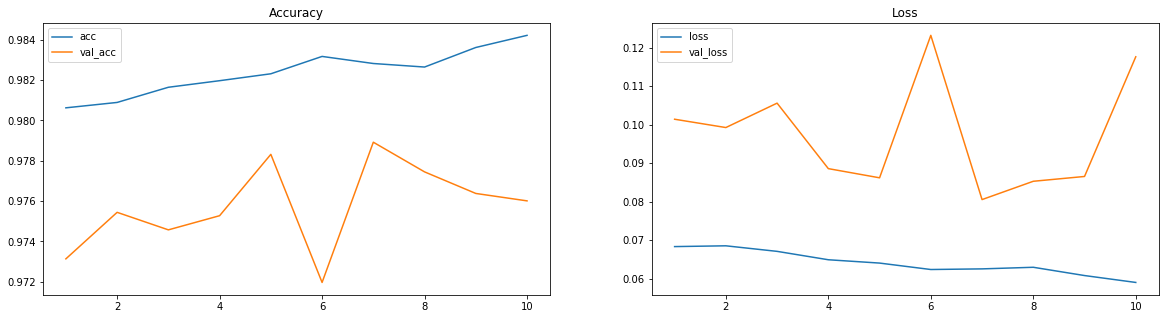

In [26]:
r = range(1, len(history_interpol.history["acc"]) + 1)

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(r, history_interpol.history["acc"], label="acc")
plt.plot(r, history_interpol.history["val_acc"], label="val_acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(r, history_interpol.history["loss"], label="loss")
plt.plot(r, history_interpol.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")

plt.show()
plt.close()

In [29]:
y_test = to_categorical(y_test)
eval_results = np.round(model.evaluate(X_test, y_test, batch_size=32, verbose=1),2)
print("Loss:     " + str(eval_results[0]))
print("Accuracy: " + str(eval_results[1]))

8810/8810 [==============================] - 2s 232us/step
Loss:     2.56
Accuracy: 0.84


In [32]:
model.

array([2.56, 0.84])

## ROC analysis

In [31]:
counter_F_neg=0
counter_F_pos=0
for i in range(X_test.shape[0]):
    if (model.predict_classes(X_test[i:(i+1),:,:])[0]!=np.nonzero(y_test[i])[0][0]):
        if model.predict_classes(X_test[i:(i+1),:,:])[0]==0:
            counter_F_neg=counter_F_neg+1
            print("False_negative i:",i,\
              "\tPred:",model.predict_classes(X_test[i:(i+1),:,:])[0],\
              "\tActual:",np.nonzero(y_test[i])[0][0],\
              "\tProbability:",round(np.max(model.predict_proba(X_test[i:(i+1),:,:])),2),)          
        else:
            counter_F_pos=counter_F_pos+1
            print("False_positive i:",i,\
              "\tPred:",model.predict_classes(X_test[i:(i+1),:,:])[0],\
              "\tActual:",np.nonzero(y_test[i])[0][0],\
              "\tProbability:",round(np.max(model.predict_proba(X_test[i:(i+1),:,:])),2))
print("\ncounter_F_neg:",counter_F_neg) 
print("\ncounter_F_pos:",counter_F_pos) 

False_negative i: 1 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 9 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 10 	Pred: 0 	Actual: 2 	Probability: 1.0
False_negative i: 14 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 16 	Pred: 0 	Actual: 2 	Probability: 1.0
False_negative i: 20 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 24 	Pred: 0 	Actual: 2 	Probability: 1.0
False_negative i: 33 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 38 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 43 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 56 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 62 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 67 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 70 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 71 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 73 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 78 	Pred: 0 	Actual: 1 	Probability: 1.0

False_negative i: 824 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 832 	Pred: 0 	Actual: 2 	Probability: 1.0
False_negative i: 841 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 843 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 846 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 857 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 875 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 878 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 884 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 885 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 889 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 903 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 910 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 921 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 930 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 938 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 953 	Pred: 0 	Actual: 

False_negative i: 1748 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 1753 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 1763 	Pred: 0 	Actual: 2 	Probability: 1.0
False_negative i: 1766 	Pred: 0 	Actual: 2 	Probability: 1.0
False_negative i: 1768 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 1779 	Pred: 0 	Actual: 2 	Probability: 1.0
False_negative i: 1781 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 1786 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 1788 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 1791 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 1792 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 1795 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 1796 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 1815 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 1829 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 1832 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 1839 	

False_negative i: 2666 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 2671 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 2676 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 2682 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 2683 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 2686 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 2690 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 2691 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 2692 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 2693 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 2694 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 2699 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 2700 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 2703 	Pred: 0 	Actual: 2 	Probability: 1.0
False_negative i: 2710 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 2718 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 2719 	

False_negative i: 3471 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 3487 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 3492 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 3496 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 3498 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 3505 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 3507 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 3513 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 3520 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 3524 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 3534 	Pred: 0 	Actual: 2 	Probability: 1.0
False_negative i: 3535 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 3548 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 3551 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 3555 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 3559 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 3560 	

False_negative i: 4370 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 4380 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 4384 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 4385 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 4388 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 4392 	Pred: 0 	Actual: 2 	Probability: 1.0
False_negative i: 4394 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 4403 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 4408 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 4410 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 4419 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 4424 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 4425 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 4426 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 4430 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 4443 	Pred: 0 	Actual: 2 	Probability: 1.0
False_negative i: 4455 	

False_negative i: 5205 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 5210 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 5215 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 5218 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 5227 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 5229 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 5242 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 5247 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 5248 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 5255 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 5265 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 5269 	Pred: 0 	Actual: 2 	Probability: 1.0
False_negative i: 5288 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 5291 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 5293 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 5303 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 5314 	

False_negative i: 6072 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 6074 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 6079 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 6081 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 6088 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 6091 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 6096 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 6098 	Pred: 0 	Actual: 2 	Probability: 1.0
False_negative i: 6105 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 6109 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 6110 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 6116 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 6119 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 6122 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 6129 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 6149 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 6180 	

False_negative i: 6937 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 6938 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 6942 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 6952 	Pred: 0 	Actual: 2 	Probability: 1.0
False_negative i: 6955 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 6960 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 6962 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 6969 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 6972 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 6984 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 6986 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 6987 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 6991 	Pred: 0 	Actual: 2 	Probability: 1.0
False_negative i: 6992 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 7001 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 7002 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 7005 	

False_negative i: 7740 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 7746 	Pred: 0 	Actual: 2 	Probability: 1.0
False_negative i: 7747 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 7757 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 7763 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 7781 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 7782 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 7817 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 7818 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 7826 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 7828 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 7833 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 7837 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 7845 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 7850 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 7851 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 7859 	

False_negative i: 8611 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 8615 	Pred: 0 	Actual: 2 	Probability: 1.0
False_negative i: 8629 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 8639 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 8644 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 8675 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 8690 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 8699 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 8708 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 8713 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 8718 	Pred: 0 	Actual: 3 	Probability: 1.0
False_negative i: 8731 	Pred: 0 	Actual: 4 	Probability: 1.0
False_negative i: 8736 	Pred: 0 	Actual: 5 	Probability: 1.0
False_negative i: 8738 	Pred: 0 	Actual: 6 	Probability: 1.0
False_negative i: 8740 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 8754 	Pred: 0 	Actual: 1 	Probability: 1.0
False_negative i: 8756 	

In [33]:
for i in range(X_test.shape[0]):
    if (model.predict_classes(X_test[i:(i+1),:,:])[0]==np.nonzero(y_test[i])[0][0]):
        print("Index:",i,\
              "\tPred:",model.predict_classes(X_test[i:(i+1),:,:])[0],\
              "\tActual:",np.nonzero(y_test[i])[0][0],\
              "\tProbability:",round(np.max(model.predict_proba(X_test[i:(i+1),:,:])),2))

Index: 0 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 4 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 5 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 6 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 7 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 8 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 11 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 12 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 13 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 15 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 17 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 18 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 19 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 21 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 22 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 23 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 25 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 26 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 27 	Pred: 0 	Actual: 0 	Probability: 1.0


Index: 215 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 216 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 217 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 218 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 219 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 220 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 221 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 222 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 223 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 224 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 225 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 227 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 228 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 229 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 230 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 231 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 233 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 234 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 235 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 236 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 237 	Pred: 0 

Index: 413 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 414 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 415 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 416 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 417 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 418 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 419 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 420 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 421 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 422 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 423 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 424 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 425 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 426 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 427 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 428 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 429 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 430 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 431 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 433 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 434 	Pred: 0 

Index: 612 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 614 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 616 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 617 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 618 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 619 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 620 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 621 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 622 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 623 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 624 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 626 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 627 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 628 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 629 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 630 	Pred: 0 	Actual: 0 	Probability: 0.99
Index: 632 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 634 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 635 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 636 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 637 	Pred: 0

Index: 826 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 827 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 828 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 829 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 830 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 831 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 833 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 834 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 835 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 836 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 837 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 838 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 839 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 840 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 842 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 844 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 845 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 847 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 848 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 849 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 850 	Pred: 0 

Index: 1019 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1020 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1021 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1022 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1023 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1024 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1025 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1026 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1028 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1029 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1031 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1032 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1033 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1034 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1035 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1036 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1037 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1038 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1040 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1041 	Pred: 0 	Actual: 0 	Probability: 1.0


Index: 1218 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1219 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1220 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1221 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1222 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1223 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1224 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1225 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1226 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1227 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1228 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1229 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1230 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1231 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1232 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1233 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1234 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1235 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1236 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1237 	Pred: 0 	Actual: 0 	Probability: 1.0


Index: 1410 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1411 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1412 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1414 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1416 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1417 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1418 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1419 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1420 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1421 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1422 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1423 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1424 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1426 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1427 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1430 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1431 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1432 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1435 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1436 	Pred: 0 	Actual: 0 	Probability: 1.0


Index: 1611 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1612 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1613 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1614 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1615 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1616 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1617 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1618 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1619 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1620 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1621 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1622 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1623 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1624 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1625 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1626 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1627 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1628 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1629 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1630 	Pred: 0 	Actual: 0 	Probability: 1.0


Index: 1817 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1818 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1819 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1820 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1821 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1822 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1823 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1824 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1825 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1826 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1827 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1828 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1830 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1831 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1833 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1834 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1835 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1836 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1837 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 1838 	Pred: 0 	Actual: 0 	Probability: 1.0


Index: 2017 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2018 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2019 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2020 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2021 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2023 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2024 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2025 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2026 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2027 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2029 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2030 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2031 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2033 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2034 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2035 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2037 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2038 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2039 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2040 	Pred: 0 	Actual: 0 	Probability: 1.0


Index: 2210 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2212 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2213 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2214 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2215 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2216 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2217 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2220 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2221 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2222 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2223 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2224 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2226 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2227 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2228 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2229 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2230 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2231 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2233 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2234 	Pred: 0 	Actual: 0 	Probability: 1.0


Index: 2407 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2409 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2410 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2411 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2412 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2413 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2414 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2415 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2416 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2417 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2418 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2419 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2420 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2421 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2422 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2423 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2425 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2426 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2427 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2428 	Pred: 0 	Actual: 0 	Probability: 1.0


Index: 2603 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2606 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2607 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2608 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2609 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2610 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2611 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2612 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2613 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2614 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2615 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2617 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2618 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2619 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2620 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2621 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2622 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2623 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2624 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2626 	Pred: 0 	Actual: 0 	Probability: 1.0


Index: 2818 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2819 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2820 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2822 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2823 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2824 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2825 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2826 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2827 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2828 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2830 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2831 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2832 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2836 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2837 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2838 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2840 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2842 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2843 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 2845 	Pred: 0 	Actual: 0 	Probability: 1.0


Index: 3014 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3015 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3016 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3017 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3018 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3019 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3020 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3021 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3022 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3023 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3026 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3027 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3028 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3029 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3030 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3032 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3033 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3034 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3035 	Pred: 0 	Actual: 0 	Probability: 1.0
Index: 3036 	Pred: 0 	Actual: 0 	Probability: 1.0


KeyboardInterrupt: 

In [37]:
y = y_test.copy()
n = y.shape[0]

label = np.zeros(n)
pred = np.zeros(n)

for i in range(n):
    label[i] = np.argmax(y[i,:])
    pred[i] = model.predict_classes(X_test[i:(i+1),:,:])
    if i % 100 == 0:
        print(i)
    
label   
pred

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800


array([0., 0., 0., ..., 0., 0., 0.])

In [49]:
for i in range(7):
    print(i,len(label[label==i]),len(pred[pred==i]))

0 7412 8809
1 217 1
2 147 0
3 238 0
4 294 0
5 276 0
6 226 0


In [50]:
100*7412/8810

84.1316685584563

### 2.4 Save model

In [ ]:
from keras.models import load_model
import h5py

In [ ]:
# save model, delete current reference and re-load it from file
model.save('models/model_gesture_interpolation_' + str(new_frmlen) + '.h5')
del model
model = load_model('005_model_gesture-interpolation.h5')

In [ ]:
type(model)